In [329]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.pipeline import Pipeline

plt.rcParams['font.family'] = 'Malgun Gothic' # 윈도우 이용자
# plt.rcParams['font.family'] = 'AppleGothic' # Mac 이용자
plt.rcParams['axes.unicode_minus'] = False

In [330]:
# 아래 데이터로 대체

# 제주 날씨 데이터 불러오기
# df_weather_jeju = pd.read_csv("dataset/weather_jeju.csv")

# df_weather_jeju.head()

# df_weather_jeju = df_weather_jeju[::4]
# print(df_weather_jeju.head())
# print(df_weather_jeju.info())
# print(df_weather_jeju.describe())
# print(df_weather_jeju.tail())

# print(df_weather_jeju["합계 일사량"])

# df_weather_jeju.hist(figsize=(16,12), bins=10)


In [331]:
# 전력 수급 현황 데이터 불러오기
# 데이터 소스
# https://www.data.go.kr/data/15125113/fileData.do
# UTF-8 인코딩 불가
df_upper = pd.read_csv("dataset/제주전력수급현황(18년~23년)/계통수요.csv", encoding="cp949") # utf-8 X
df_bottom = pd.read_csv("dataset/제주전력수급현황(23년~25년)/계통수요.csv", encoding="cp949") # utf-8 X

print(f"18년~23년 데이터 수: {len(df_upper)}")
print(f"23년~25년 데이터 수: {len(df_bottom)}")

print(df_upper.tail())
print(df_bottom.head())

df_demand = pd.concat([df_upper, df_bottom], axis=0)
print(len(df_demand))

df_demand["전력수요총합"] = df_demand.iloc[:, 1:].sum(axis=1)
print(df_demand.info())
# print(df_demand.head())


df_demand_sum = df_demand[["날짜", "전력수요총합"]]
print(df_demand_sum.head())


18년~23년 데이터 수: 2069
23년~25년 데이터 수: 608
              날짜     1시     2시     3시     4시     5시     6시     7시     8시  \
2064  2023-08-27  685.5  643.5  610.3  592.4  589.1  600.2  615.3  637.7   
2065  2023-08-28  715.7  676.4  648.6  629.8  622.7  634.8  669.5  747.2   
2066  2023-08-29  739.2  694.8  661.9  640.6  636.1  646.4  685.2  761.9   
2067  2023-08-30  730.5  683.6  655.0  631.1  629.5  644.3  675.9  760.2   
2068  2023-08-31  671.3  628.1  600.5  583.8  580.0  596.8  629.1  689.6   

         9시  ...    15시    16시    17시     18시     19시     20시    21시    22시  \
2064  671.1  ...  811.6  834.5  876.0   923.9   942.2   954.7  932.1  883.2   
2065  834.8  ...  967.3  986.8  992.6  1003.6  1003.4  1009.9  973.9  918.7   
2066  844.3  ...  984.6  989.8  979.6   978.9   980.6   992.3  959.0  902.9   
2067  852.9  ...  865.6  879.7  886.7   884.2   876.3   883.5  853.9  807.7   
2068  755.9  ...  829.7  848.8  854.5   872.6   885.0   891.0  865.0  819.4   

        23시    24시  
2064  82

# 전처리

In [332]:
# 날씨 데이터 2015년~2025년
df_temp = pd.read_csv("dataset/기온데이터.csv", encoding="utf8")
df_sun = pd.read_csv("dataset/일조량데이터.csv", encoding="cp949")
df_wind = pd.read_csv("dataset/풍속데이터.csv", encoding="cp949")
df_rain = pd.read_csv("dataset/강수량데이터.csv", encoding='cp949')
df_hum = pd.read_csv("dataset/습도데이터.csv", encoding='utf8')

# 풍향풍속데이터 전처리
# 필요없는 컬럼 제거
df_wind = df_wind.iloc[:, :4]

# # 강수량 데이터 결측치 0으로 채워놓기
df_rain.fillna(0, inplace=True)

# 각 데이터 프레임 컬럼명 변경
df_temp.columns = ['일시', '평균기온', '최고기온', '최저기온']
df_sun.columns = ['일시', '일조합', '일조율', '일사합']
df_wind.columns = ['일시', '평균풍속', '최대풍속', '최대풍속풍향']
df_rain.columns = ['일시', '강수량']
df_hum.columns = ["일시", "평균습도", "최저습도"]

# 일시 컬럼 삭제
print(df_temp.info())
df_temp = df_temp[['일시', '평균기온', '최고기온', '최저기온']]
df_sun = df_sun.iloc[:, 1:]
df_wind = df_wind.iloc[:, 1:]
df_rain = df_rain.iloc[:, 1:]
df_hum = df_hum.iloc[:, 1:]

# 합치기
df_weather = pd.concat([df_temp, df_sun, df_wind, df_rain, df_hum], axis=1)
print(df_weather)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3862 entries, 0 to 3861
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일시      3862 non-null   object 
 1   평균기온    3859 non-null   float64
 2   최고기온    3862 non-null   float64
 3   최저기온    3862 non-null   float64
dtypes: float64(3), object(1)
memory usage: 120.8+ KB
None
              일시  평균기온  최고기온  최저기온   일조합   일조율    일사합  평균풍속  최대풍속  최대풍속풍향  \
0     2015-01-01   3.3   5.4   1.7   0.2   2.0   3.35   8.3  12.9   320.0   
1     2015-01-02   6.1   8.5   3.9   1.5  15.0   4.98   6.3   9.7   290.0   
2     2015-01-03   6.8   9.6   3.5   4.5  45.0   8.18   2.1   3.7   290.0   
3     2015-01-04  11.5  15.0   7.7   8.4  84.0  10.06   2.8   4.3   250.0   
4     2015-01-05  12.9  17.5   6.8   3.6  36.0   7.48   2.2   7.2   200.0   
...          ...   ...   ...   ...   ...   ...    ...   ...   ...     ...   
3858  2025-07-25  28.8  31.9  26.9   9.3  66.4  23.87   3.9   7.0    70.0 

<Axes: title={'center': '결측치 개수'}>

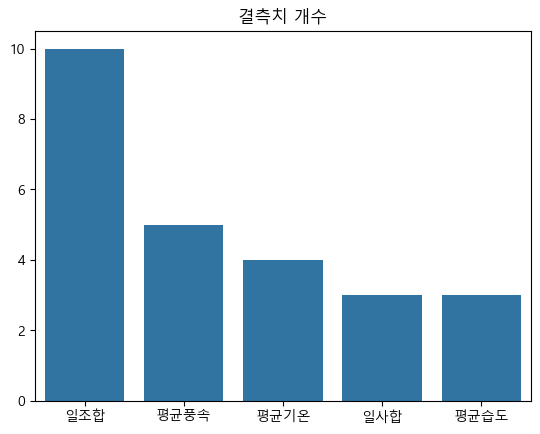

In [333]:
# 결측치 표현하기
plt.title("결측치 개수")
sns.barplot(df_weather.isnull().sum().sort_values( ascending=False)[:5]) # 순위 5등까지

In [334]:
# 날씨 데이터 + 전력 수요
df = pd.merge(df_weather, df_demand_sum, left_on="일시", right_on="날짜", how='inner')
df.drop('날짜', axis=1, inplace=True)

# 일시 데이터 연, 월, 일 분개
df["일시"] = pd.to_datetime(df["일시"])
df["연"] = df["일시"].dt.year
df["월"] = df["일시"].dt.month
df["일"] = df["일시"].dt.day

print(df.head())
print(df.tail())
print(df.info())
print(df.describe())
null_rows_index = df[df.isnull().any(axis=1)].index
print(null_rows_index)

          일시  평균기온  최고기온  최저기온  일조합   일조율    일사합  평균풍속  최대풍속  최대풍속풍향  강수량  \
0 2018-01-01   6.4   8.8   4.0  2.7  27.0   5.97   3.5   7.2   360.0  0.0   
1 2018-01-02   7.0  10.1   3.0  8.2  82.0  10.53   2.2   5.5   360.0  0.0   
2 2018-01-03   5.0   8.4   3.5  3.2  32.0   7.84   3.4   6.0   360.0  0.0   
3 2018-01-04   3.9   4.6   2.4  0.0   0.0   2.19   2.6   5.5    20.0  0.6   
4 2018-01-05   5.1   6.5   1.9  0.0   0.0   1.26   4.1   7.3   320.0  4.2   

   평균습도  최저습도   전력수요총합     연  월  일  
0  53.4  41.0  15744.3  2018  1  1  
1  53.5  35.0  16917.8  2018  1  2  
2  60.3  52.0  17103.2  2018  1  3  
3  70.0  60.0  17719.1  2018  1  4  
4  70.5  57.0  17964.2  2018  1  5  
             일시  평균기온  최고기온  최저기온   일조합   일조율    일사합  평균풍속  최대풍속  최대풍속풍향  강수량  \
2672 2025-04-26  15.7  20.2  10.6  12.4  92.5  27.98   2.5   4.8    20.0  0.0   
2673 2025-04-27  16.6  21.0  12.8   6.5  48.5  17.53   1.6   4.0    20.0  4.1   
2674 2025-04-28  15.5  19.5  12.2   8.7  64.9  23.60   3.9   6.8    20.0

# 데이터 시각화

<Axes: >

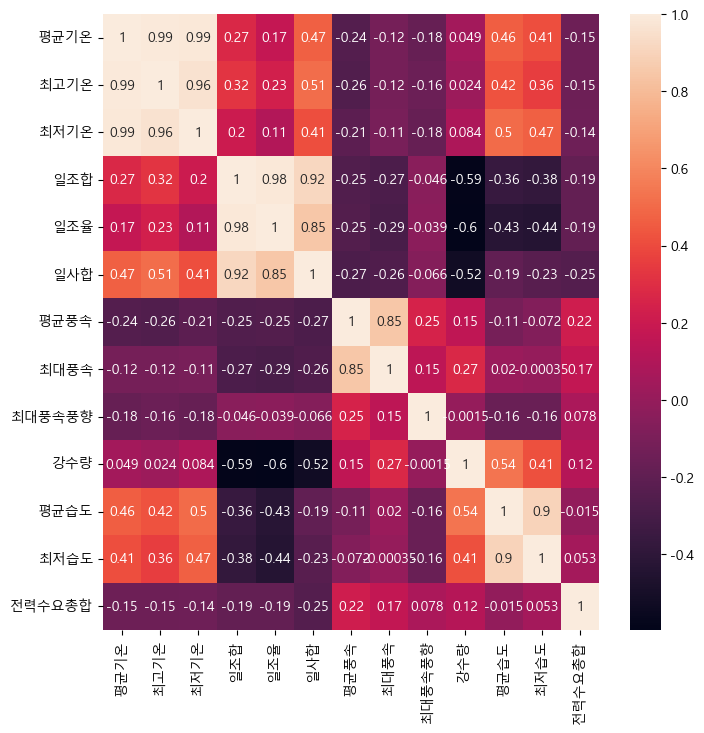

In [335]:
# 성분 간 관계 분석
plt.figure(figsize=(8,8))
sns.heatmap(df.iloc[:, :-3].corr(numeric_only=True, method="spearman"), annot=True,)

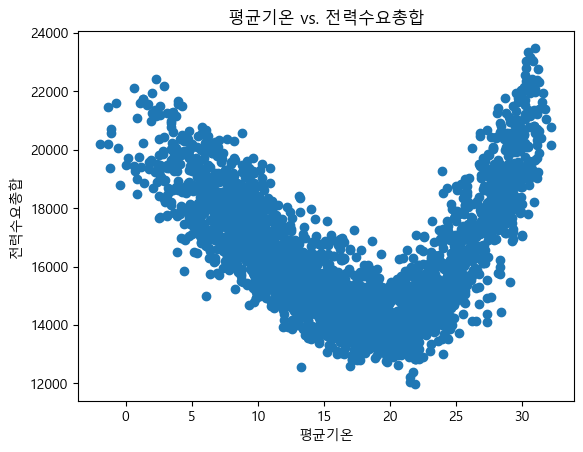

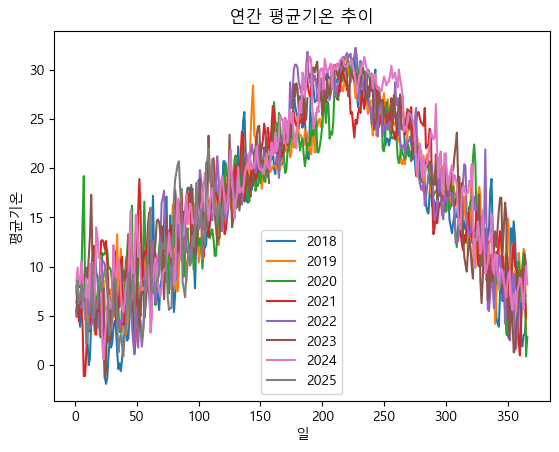

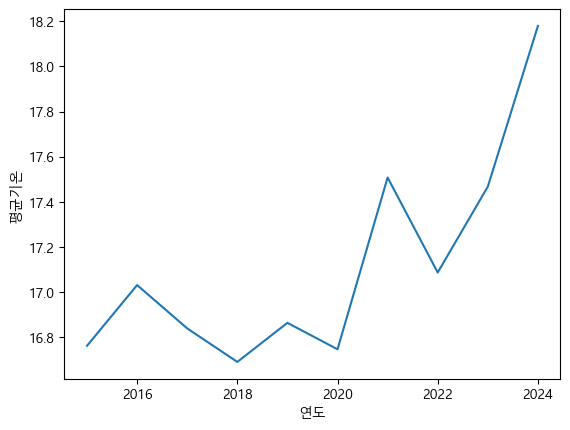

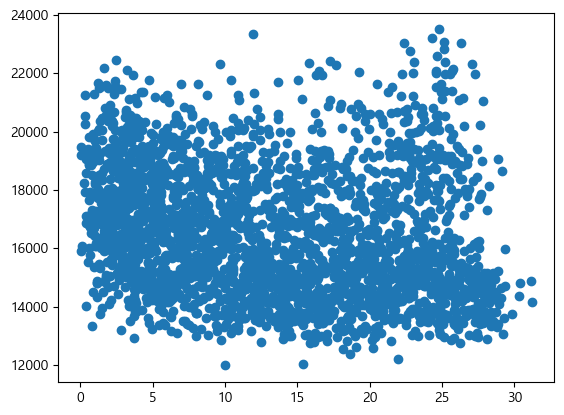

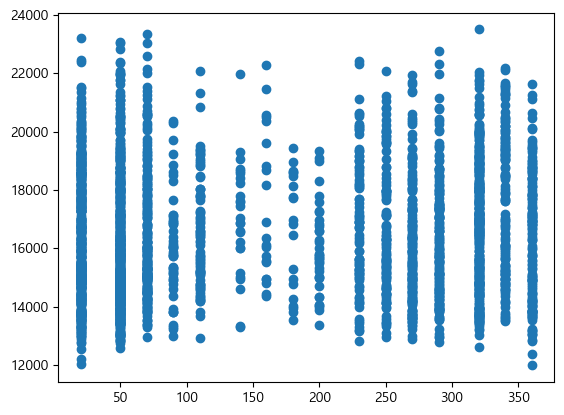

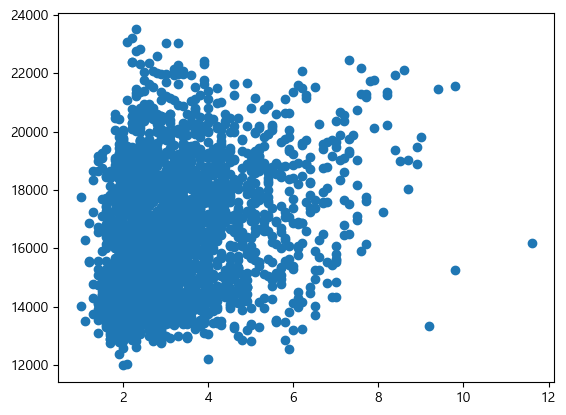

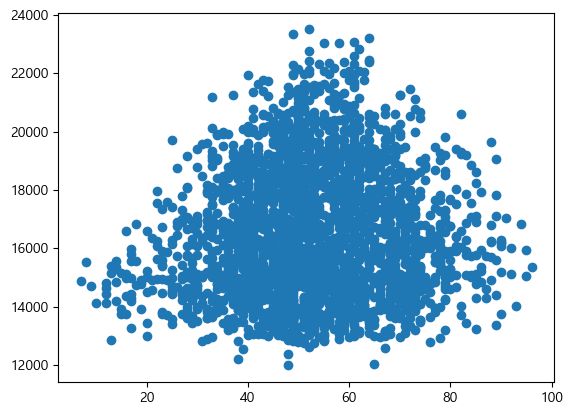

In [336]:

# 평균기온 vs. 전력수요총합 산점도
plt.scatter(df["평균기온"], df["전력수요총합"])
plt.xlabel("평균기온")
plt.ylabel("전력수요총합")
plt.title("평균기온 vs. 전력수요총합")
plt.show()

# 연도별 일자 평균기온 데이터
fig, ax = plt.subplots()
for year in range(2018, 2026):
    df_yearly = df.loc[(df["연"] >= year) & (df["연"] < year+1), ]
    ax.plot(df_yearly["일시"].dt.dayofyear, df_yearly["평균기온"], label=f"{year}")
    ax.legend()
    
plt.xlabel("일")
plt.ylabel("평균기온")
plt.title('연간 평균기온 추이')
plt.show()

# 연도별 일자 평균기온 데이터
df_weather["일시"] = pd.to_datetime(df_weather["일시"])
df_weather["연"] = df_weather["일시"].dt.year
sr_high_temp = df_weather.groupby("연")["평균기온"].mean()
df_high_temp = pd.DataFrame({
    "연도": sr_high_temp.index,
    "평균기온": sr_high_temp.values,
})
sns.lineplot(df_high_temp[:-1], x="연도", y="평균기온")
plt.show()

# 합계 일사량 vs. 전력수요총합
plt.scatter(df["일사합"], df["전력수요총합"])
plt.show()

# 최대풍속풍향 vs. 전력수요총합
plt.scatter(df["최대풍속풍향"], df["전력수요총합"])
plt.show()

# 최대풍속 vs. 전력수요총합
plt.scatter(df["평균풍속"], df["전력수요총합"])
plt.show()

# 최저습도 vs. 전력수요총합
plt.scatter(df["최저습도"], df["전력수요총합"])
plt.show()

결측값 제거 전 관측치 개수: 2677
결측값 제거 후 관측치 개수: 2661


<Axes: >

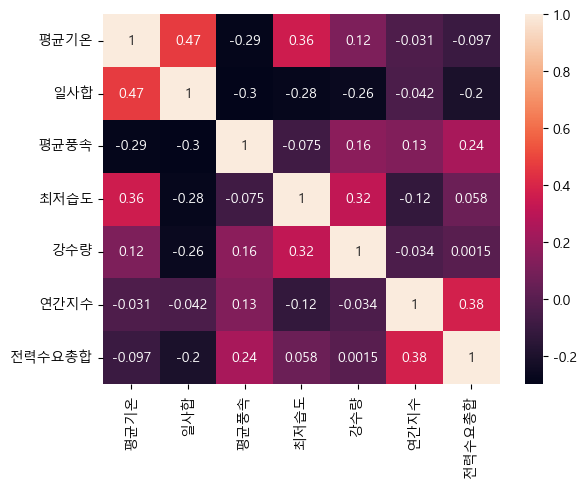

In [337]:
# 필요 데이터 컬럼 추려내기
print(f"결측값 제거 전 관측치 개수: {len(df)}")
df.dropna(inplace=True)

print(f"결측값 제거 후 관측치 개수: {len(df)}")

df["연간지수"] = df["연"] - 2018
selected_columns = ["평균기온", "일사합", "평균풍속", "최저습도", "강수량", "연간지수", "전력수요총합"]
df = df[selected_columns]
sns.heatmap(df.corr(), annot=True)

# 예측 모델

## 다항 회귀 머신러닝

   평균기온    일사합  평균풍속  최저습도  강수량  연간지수   전력수요총합
0   6.4   5.97   3.5  41.0  0.0     0  15744.3
1   7.0  10.53   2.2  35.0  0.0     0  16917.8
2   5.0   7.84   3.4  52.0  0.0     0  17103.2
3   3.9   2.19   2.6  60.0  0.6     0  17719.1
4   5.1   1.26   4.1  57.0  4.2     0  17964.2


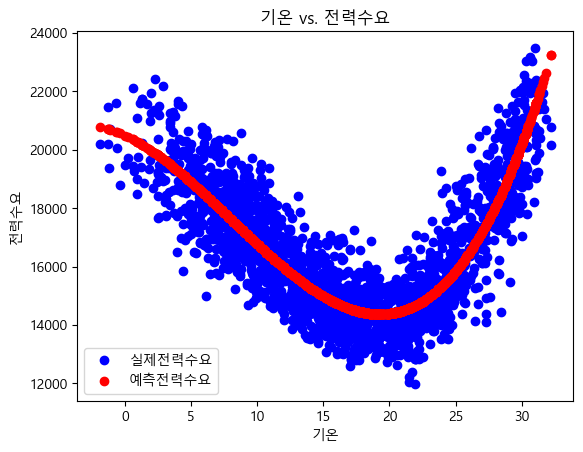

R-squared: 0.7506
MSE: 1140988.6147
RSME: 1068.1706861200937
MAE: 863.0535020715813


In [338]:
print(df.head()) # 컬럼 확인 용도
X = df.iloc[:, 0].values.reshape(-1, 1)
y = df["전력수요총합"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
poly = Pipeline([("poly",PolynomialFeatures(degree=3)), ("model",LinearRegression())])
poly.fit(X_train, y_train)

y_pred = poly.predict(X_train)
r_squared = r2_score(y_train, y_pred)

plt.scatter(X_train[:, 0], y_train, color="blue")
plt.scatter(X_train[:, 0], y_pred, color="red")
plt.title("기온 vs. 전력수요")
plt.legend(["실제전력수요", "예측전력수요"])
plt.xlabel("기온")
plt.ylabel("전력수요")
plt.show()

y_test_pred = poly.predict(X_test)

print(f"R-squared: {r_squared:.4f}")
print(f"MSE: {mean_squared_error(y_test, y_test_pred):.4f}")
print(f"RSME: {root_mean_squared_error(y_test, y_test_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred)}")

   평균기온    일사합  평균풍속  최저습도  강수량  연간지수   전력수요총합
0   6.4   5.97   3.5  41.0  0.0     0  15744.3
1   7.0  10.53   2.2  35.0  0.0     0  16917.8
2   5.0   7.84   3.4  52.0  0.0     0  17103.2
3   3.9   2.19   2.6  60.0  0.6     0  17719.1
4   5.1   1.26   4.1  57.0  4.2     0  17964.2


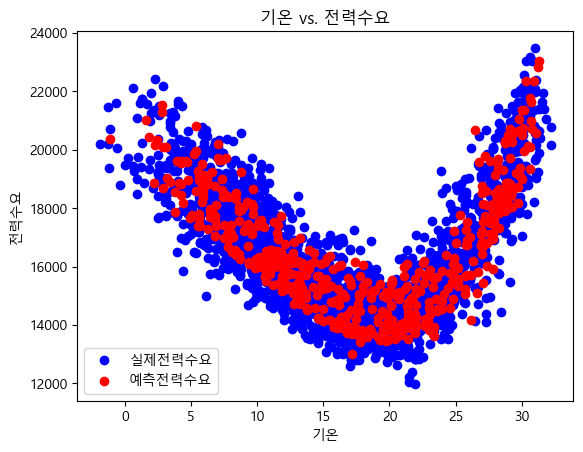

R-squared: 0.8806
MSE: 565563.5408
RSME: 752.0395872656389
MAE: 585.5715853684046


In [340]:
print(df.head()) # 컬럼 확인 용도
X = df.iloc[:, :-1].values.reshape(-1, 6)
y = df["전력수요총합"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipe = Pipeline([("poly",PolynomialFeatures(degree=3)), ("model",LinearRegression())])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

plt.scatter(X_train[:, 0], y_train, color="blue")
plt.scatter(X_test[:, 0], y_pred, color="red")
plt.title("기온 vs. 전력수요")
plt.xlabel("기온")
plt.ylabel("전력수요")
plt.legend(["실제전력수요", "예측전력수요"])
plt.show()

y_test_pred = pipe.predict(X_test)
r_squared = r2_score(y_test, y_test_pred)

print(f"R-squared: {r_squared:.4f}")
print(f"MSE: {mean_squared_error(y_test, y_test_pred):.4f}")
print(f"RSME: {root_mean_squared_error(y_test, y_test_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred)}")

[-1.37879997e-08  1.46765842e+02 -2.37838338e+02  1.68984644e+02
 -8.10085132e+00  1.12729452e+02  7.80240904e+02 -3.78903965e+01
 -1.02032735e+00  2.42542529e+01 -7.12141248e+00 -4.50635951e+00
 -2.89752454e+01  1.11658949e+01  1.98378820e+01  2.24216166e+00
 -5.36805796e-01 -3.15571636e+01  1.43104832e+00 -1.33017198e+01
 -3.74912195e+00 -1.29817678e+02  9.78988836e-01 -3.29557035e-01
 -8.36202751e-01 -1.08988825e-01 -1.27744838e+01  6.85292682e+01
  1.03755907e+00 -6.94199720e-02 -1.33528300e-01  2.36873625e-01
 -8.39838156e-02  8.38521674e-01  1.28110056e-01 -9.40691195e-01
  5.10979155e-02  2.35039576e-01  4.25661787e-01 -3.65013096e-01
 -1.92774709e-01  1.62526158e-01 -5.63765214e-01  7.53602049e-03
  6.34980322e-02 -7.32469313e-02  8.99932473e-03  4.03101280e-01
  7.41539212e-01 -1.64430597e-01 -3.48396085e-01 -6.78601101e-02
 -9.01952604e-02 -1.47466768e-01 -1.80807695e+00  2.00312507e-01
 -5.38659718e-02  3.00777956e+00 -1.69962886e-02 -3.80742290e-02
 -1.19604938e-02 -1.79318

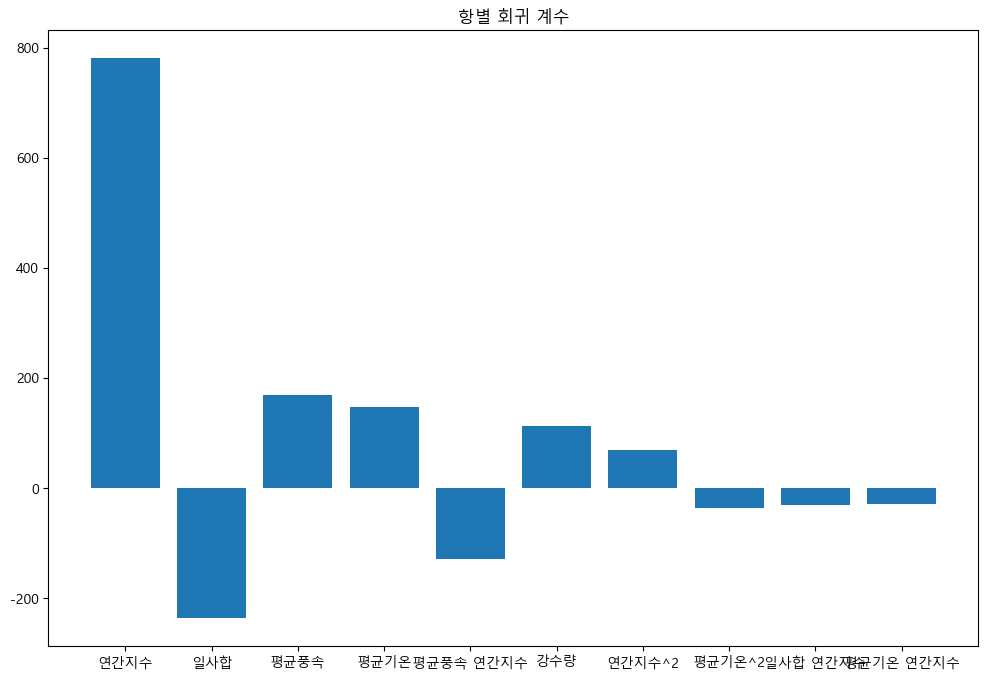

In [342]:
# 회귀 계수 추출
coefs = pipe.named_steps['model'].coef_

print(coefs)
# 생성된 feature 이름
feature_names = pipe.named_steps['poly'].get_feature_names_out(["평균기온", "일사합", "평균풍속", "최저습도", "강수량", "연간지수"])
print(feature_names)

print(len(coefs), len(feature_names))
# 중요도 출력
importance_df = pd.DataFrame({
    '변수': feature_names,
    '수치': coefs,
    "절대값": abs(coefs)
}).sort_values(by='절대값', ascending=False)

plt.figure(figsize=(12,8))
plt.bar(importance_df["변수"][:10], importance_df["수치"][:10])
plt.title("항별 회귀 계수")
plt.show()

# 랜덤 포레스트 트리

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print(df.head())
X = df.iloc[:, :-1].values.reshape(-1, 6)
y = df["전력수요총합"].values

   평균기온    일사합  평균풍속  최저습도  강수량  연   전력수요총합
0   6.4   5.97   3.5  41.0  0.0  0  15744.3
1   7.0  10.53   2.2  35.0  0.0  0  16917.8
2   5.0   7.84   3.4  52.0  0.0  0  17103.2
3   3.9   2.19   2.6  60.0  0.6  0  17719.1
4   5.1   1.26   4.1  57.0  4.2  0  17964.2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [2, 4, 8],
    'max_features': [4, 8, 16]
}
trainer = GridSearchCV(RandomForestRegressor(criterion="squared_error", random_state=42), param_grid = param_grid)
trainer.fit(X_train, y_train)
model = trainer.best_estimator_

In [343]:
model

,n_estimators,400
,criterion,'squared_error'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,4
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


R-squared: 0.8756


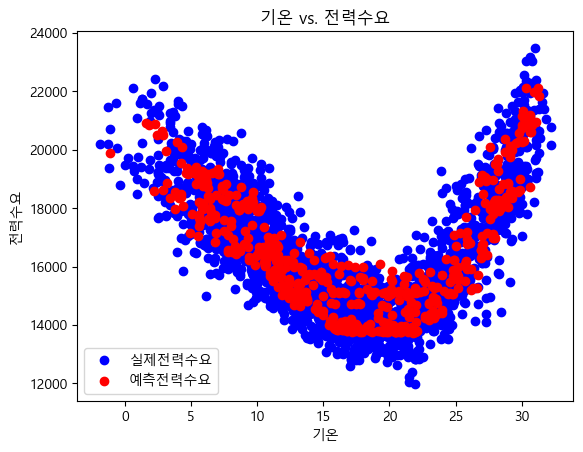

MSE: 589458.6435
RSME: 767.762100848631
MAE: 594.9113089395087


In [344]:
y_pred = model.predict(X_test)
r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared:.4f}")

plt.scatter(X_train[:, 0], y_train, color="blue")
plt.scatter(X_test[:, 0], y_pred, color="red")

y_test_pred = model.predict(X_test)

plt.title("기온 vs. 전력수요")
plt.xlabel("기온")
plt.ylabel("전력수요")
plt.legend(["실제전력수요", "예측전력수요"])
plt.show()
print(f"MSE: {mean_squared_error(y_test, y_test_pred):.4f}")
print(f"RSME: {root_mean_squared_error(y_test, y_test_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred)}")

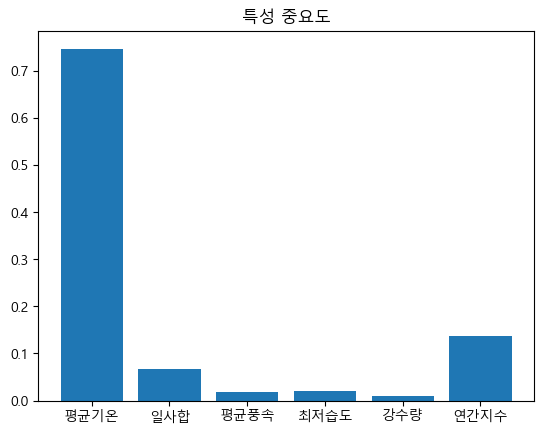

In [345]:
feature_importances = pd.DataFrame({
    "변수": df.columns[:-1],
    "중요도": model.feature_importances_
})

plt.bar(feature_importances["변수"], feature_importances["중요도"])
plt.title("특성 중요도")
plt.show()

In [346]:
# 실제데이터 예측값
df_rest_weather = df_weather[df_weather["일시"] > "2025-04-30"]
df_rest_weather.dropna(inplace=True)
df_rest_weather['연'] = df_rest_weather['연'] - 2018
df_rest_weather.tail()


X_rest = df_rest_weather[selected_columns].values
y_rest_pred = model.predict(X_rest)


df_pred = pd.DataFrame({
    "일시": df_rest_weather["일시"],
    "전력수요": y_rest_pred
})
sns.lineplot(df_pred, x="일시", y="전력수요")
plt.title("전력수요예측")
plt.show()

C:\Users\human-03\AppData\Local\Temp\ipykernel_17196\4292857164.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rest_weather.dropna(inplace=True)
C:\Users\human-03\AppData\Local\Temp\ipykernel_17196\4292857164.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rest_weather['연'] = df_rest_weather['연'] - 2018


KeyError: "['연간지수', '전력수요총합'] not in index"

In [348]:
joblib.dump(model, 'model_elec_demand.pkl')

['model_elec_demand.pkl']